# | Imports, functions & data load

## | Reset variables

Notebook variables reset for each complete execution of this code :

In [1]:
%reset -f

## | Installations & Imports

### | Installations

In [2]:
# %pip install catboost

In [3]:
# %pip install xgboost

In [4]:
# %pip install imblearn

In [5]:
# %pip install shap

In [6]:
# %pip install tqdm

In [7]:
# %pip install lightgbm

### | Imports

In [8]:
import autopep8

import pandas as pd
import seaborn as sns
import numpy as np
import time
import pickle
import joblib
import matplotlib.pyplot as plt
import array as arr
from tqdm import tqdm
import sklearn
print("Scikit-Learn Version : {}".format(sklearn.__version__))

from zipfile import ZipFile

# Preprocessing, Imputing, Upsampling, Model Selection, Model Evaluation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from collections import Counter

from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, make_scorer, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import get_scorer_names


#Predictive Models

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

# Interpreting Predictions

import shap
print("SHAP Version : {}".format(shap.__version__))

Scikit-Learn Version : 1.1.2
SHAP Version : 0.41.0


## | Analyse Custom Scorer | fonction métier

### | Définition du Seuil

La question que l'on doit se poser est: à partir de quel **seuil de probabilité** allons nous choisir de classer le client comme un **client de confiance** ou un **client à risques**?

**Implications métier :**

-  **Ne pas prêter** d'argent à un client qui **aurait remboursé** son prêt est un **manque à gagner** pour l'entreprise.


-  Cependant, lorsque l'entreprise **prête** à un client qui ne **pourra pas rembourser** son prêt, il s'agit d'une **perte sèche**.


-  **Risque** de prêt à client qui **ne remboursera pas** > **Gain** à prêter à un client qui **remboursera**

Il nous faut donc déterminer les **coûts** lorsque l'entreprise **prête** à un mauvais client, comparé aux **coûts** d'un **refus de prêt** à un bon client.

**FN**(Faux Bon Client): Prêt à tort ===> Perte du capital ou partie du capital ===> Perte de beaucoup d'argent<br>
**FP**(Faux Mauvais Client): Refus à tort de prêt ===> Perte de Marge, Manque à gagner

**Hypothèse:** Nous partons d'un capital de 100.

 - FN ---> Perte de 50% du capital prêté en moyenne ---> Perte de 50
 - FP ---> Manque à gagner de 1%/an sur en moyenne 10ans<br>
(capital va de 100 à 0 soit moyenne de 50) ---> 10% de 50 ---> Perte de 5

**Rapport de coût entre FN et FP:**

Les FN coûtent 10 fois plus chers que les FP, **1xFN = 10FP**

**Objectif:**

 - Optimiser la Matrice de confusion en optimisant la somme de ces 2 coûts.
 - Fonction à minimiser:

**Min(10FN + FP)**

 - Tester tous les seuils et calculer cette fonction

### | Alternatives pour la fonction coût métier

La fonction reprenant les FP et FN est créée au paragraphe:<br>
**Functions | Création de la fonction coût métier**

Une autre alternative possible est  également de créer un custom score qui impacterait plus le rappel que la précision, de type FBeta score:

In [9]:
fthree_scorer = make_scorer(fbeta_score, beta=3)
fthree_scorer

make_scorer(fbeta_score, beta=3)

## | Functions

### | Création de la fonction coût métier

Optimiser la Matrice de confusion en optimisant la somme de ces 2 coûts.<br>
Résoudre: Min(10FN +FP) --> fonction à minimiser

In [10]:
# fonction métier à partir de la matrice de confusion
def custom_metric(y_true, y_pred):
    """Fonction qui extraie de la matrice de confusion les
    valeurs des 4 mesures et retourne un calcul sur base
    d'une pondération de FP et FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (10*fn + fp)/len(y_true)

# un custom_auc
def custom_auc_metric(y_true, y_pred_proba):
    """Fonction qui permet d'utiliser les mêmes entrées que
    custom_metric sans utiliser y_pred mais y_proba à la place"""
    return roc_auc_score(y_true, y_pred_proba)

In [11]:
# creation du custom_score métier sur base du custom_metric pour guider le GridsearchCV
custom_score = make_scorer(custom_metric, greater_is_better=False)

In [12]:
# creation du custom_auc sur base du custom_auc_metric
custom_auc = make_scorer(custom_auc_metric, greater_is_better=True, needs_proba=True)

**Modification : scores = uniquement 'custom_score' (retiré custom_auc)**

In [13]:
scores = {'custom_score': custom_score}

In [14]:
scores

{'custom_score': make_scorer(custom_metric, greater_is_better=False)}

### | Confusion Matrix and ROC Area Under the Curve

In [15]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, dataset):
    '''This function will make a pretty plot of a
    sklearn Confusion Matrix using a 
    Seaborn heatmap visualization + ROC Curve.'''
    
    # global indices
    fig = plt.figure(figsize=(10, 10))
    
    # plot Confusion Matrix
    plt.subplot(221)
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    
    # plot Area Under the Curve (ROC)
    plt.subplot(222)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    # plot no-skill curve
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='No Skill')
    # plot the ROC_AUC curve
    if dataset=="train":
        plt.plot(fpr, tpr, color='orange', linewidth=5,
             label='ROC_AUC (train) = %0.4f' %roc_auc1)
    elif dataset=="test":
        plt.plot(fpr, tpr, color='orange', linewidth=5,
             label='ROC_AUC (test) = %0.4f' %roc_auc2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()

    
    # plot Area Under the Curve (Precision-Recall)
    plt.subplot(212)
    # predict class values
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    no_skill = len(y_true[y_true==1]) / len(y_true)
    # plot no-skill curve
    plt.plot([0, 1], [no_skill, no_skill], color='darkblue', linestyle='--', label='No Skill')
    # calculate precision-recall AUC
    pr_auc = auc(recall, precision)
    # plot the precision-recall curves
    if dataset=="train":
        plt.plot(recall, precision, color='orange', linewidth=5,
             label='PR_AUC (train) = %0.4f' %pr_auc)
    elif dataset=="test":
        plt.plot(recall, precision, color='orange', linewidth=5,
             label='PR_AUC (test) = %0.4f' %pr_auc)    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    # show the plot   
    plt.show()

### | Model Comparison | Confusion Matrix and ROC / PR AUC curves

In [16]:
model_names = ["Dummy", "LogReg", "RandFor", "CatBoost", "XGBC", "LightGBM", "LightGBM_NS"]

In [17]:
def cf_matrix_compare(dataset):
    '''This function will make plot of
    Confusion Matrixes using a 
    Seaborn heatmap visualization
    for all models trained / tested.'''
    
    # global indices
    group_names = ['No Default', 'Default']
    fig, axs = plt.subplots(1, 7, figsize=(25, 5), sharey='row')
    fig.set_facecolor('lightgrey')
        
    for i, model in enumerate(model_names):
        # plot Confusion Matrixes | axs[row, col]
        if dataset=="train":
            cf_matrix = confusion_matrix(y_train, predictions_1[i])
            fig.text(0.4, 0.1, 'Predicted label (train)', ha='left')
        elif dataset=="test":
            cf_matrix = confusion_matrix(y_test, predictions_2[i])
            fig.text(0.4, 0.1, 'Predicted label (test)', ha='left')

        disp = ConfusionMatrixDisplay(cf_matrix,
                                      display_labels=group_names)

        disp.plot(ax=axs[i], xticks_rotation=45)
        disp.ax_.set_title(model)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        axs[i].grid(False)
        if i!=0:
            disp.ax_.set_ylabel('')

    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    
    fig.colorbar(disp.im_, ax=axs)
    plt.show()

In [18]:
def auc_compare(dataset):
    '''This function will make plot of a
    ROC and PR Curves of all models tested,
    and return PR_AUC values.'''
    
    # global indices
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # instantiate dictionaries
    pr_auc_val_train=[]
    pr_auc_val_test=[]
    
    # plot Area Under the Curve (ROC)
    plt.subplot(121)
    
    for i, model in enumerate(model_names):
        # plot ROC_AUC curves
        if dataset=="train":
            fpr, tpr, _ = roc_curve(y_train, pred_proba_1[i])
            plt.plot(fpr, tpr, color=col[i], linewidth=4, label=f"{model}AUC (train) = {round(roc_auc_1[i], 4)}")
        elif dataset=="test":
            fpr, tpr, _ = roc_curve(y_test, pred_proba_2[i])
            plt.plot(fpr, tpr, color=col[i], linewidth=4, label=f"{model}AUC (test) = {round(roc_auc_2[i], 4)}")
  
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
        
    # plot Area Under the Curve (Precision-Recall)
    plt.subplot(122)
   
    for i, model in enumerate(model_names):
    # predict class values
        if dataset=="train":
            precision, recall, _ = precision_recall_curve(y_train, pred_proba_1[i])
            # calculate precision-recall AUC
            pr_auc = auc(recall, precision)
            # add pr_auc value to list for the final presentation dataframe 
            pr_auc_val_train.append(pr_auc)
            # plot the precision-recall curves
            plt.plot(recall, precision, color=col[i], linewidth=4,
                     label=f"{model}PR_AUC (train) = {round(pr_auc, 4)}")
            
        elif dataset=="test":
            precision, recall, _ = precision_recall_curve(y_test, pred_proba_2[i])
            # calculate precision-recall AUC
            pr_auc = auc(recall, precision)
            # add pr_auc value to list for the final presentation dataframe 
            pr_auc_val_test.append(pr_auc)
            # plot the precision-recall curves
            plt.plot(recall, precision, color=col[i], linewidth=4,
                     label=f"{model}PR_AUC (test) = {round(pr_auc, 4)}")

    no_skill = len(y_train[y_train==1]) / len(y_train)
    # plot no-skill curve
    plt.plot([0, 1], [no_skill, no_skill], color='darkblue', linestyle='--', label='No Skill')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    plt.show()
    
    return pr_auc_val_train, pr_auc_val_test

## | Parameters & Data load

In [19]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [20]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

In [21]:
z = ZipFile("data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'),
                         index_col='SK_ID_CURR', encoding='utf-8')
# data_train = pd.read_csv(z.open('data_train.csv'),
#                          encoding='utf-8')

In [22]:
data_train.shape

(307507, 114)

In [23]:
TARGET = pd.read_csv('TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307507, 1)

In [24]:
data_train["TARGET"] = TARGET

# | Data preparation for model

## | Manual reduction of feature number

Basé sur une première itération ayant fourni des features finales peu explicatives, nous retirons ces features pour laisser place à celles ayant réellement un impact sur la TARGET:

Liste features_to_remove à compléter au besoin pour retirer des features qui ne semblent pas expliquer correctement TARGET, et qui sont juste corrélées, mais sans relation de cause à effet côté métier. 

In [25]:
# features_to_remove = []

In [26]:
# data_train[[features_to_remove]]

## | Outliers (Outliers --> np.nan --> Imputation --> median)

In [27]:
# get categorical and quantitative columns

cat_cols = list(data_train.select_dtypes(exclude=[np.number]).columns)
quant_cols = list(data_train.select_dtypes(include=[np.number]).columns)

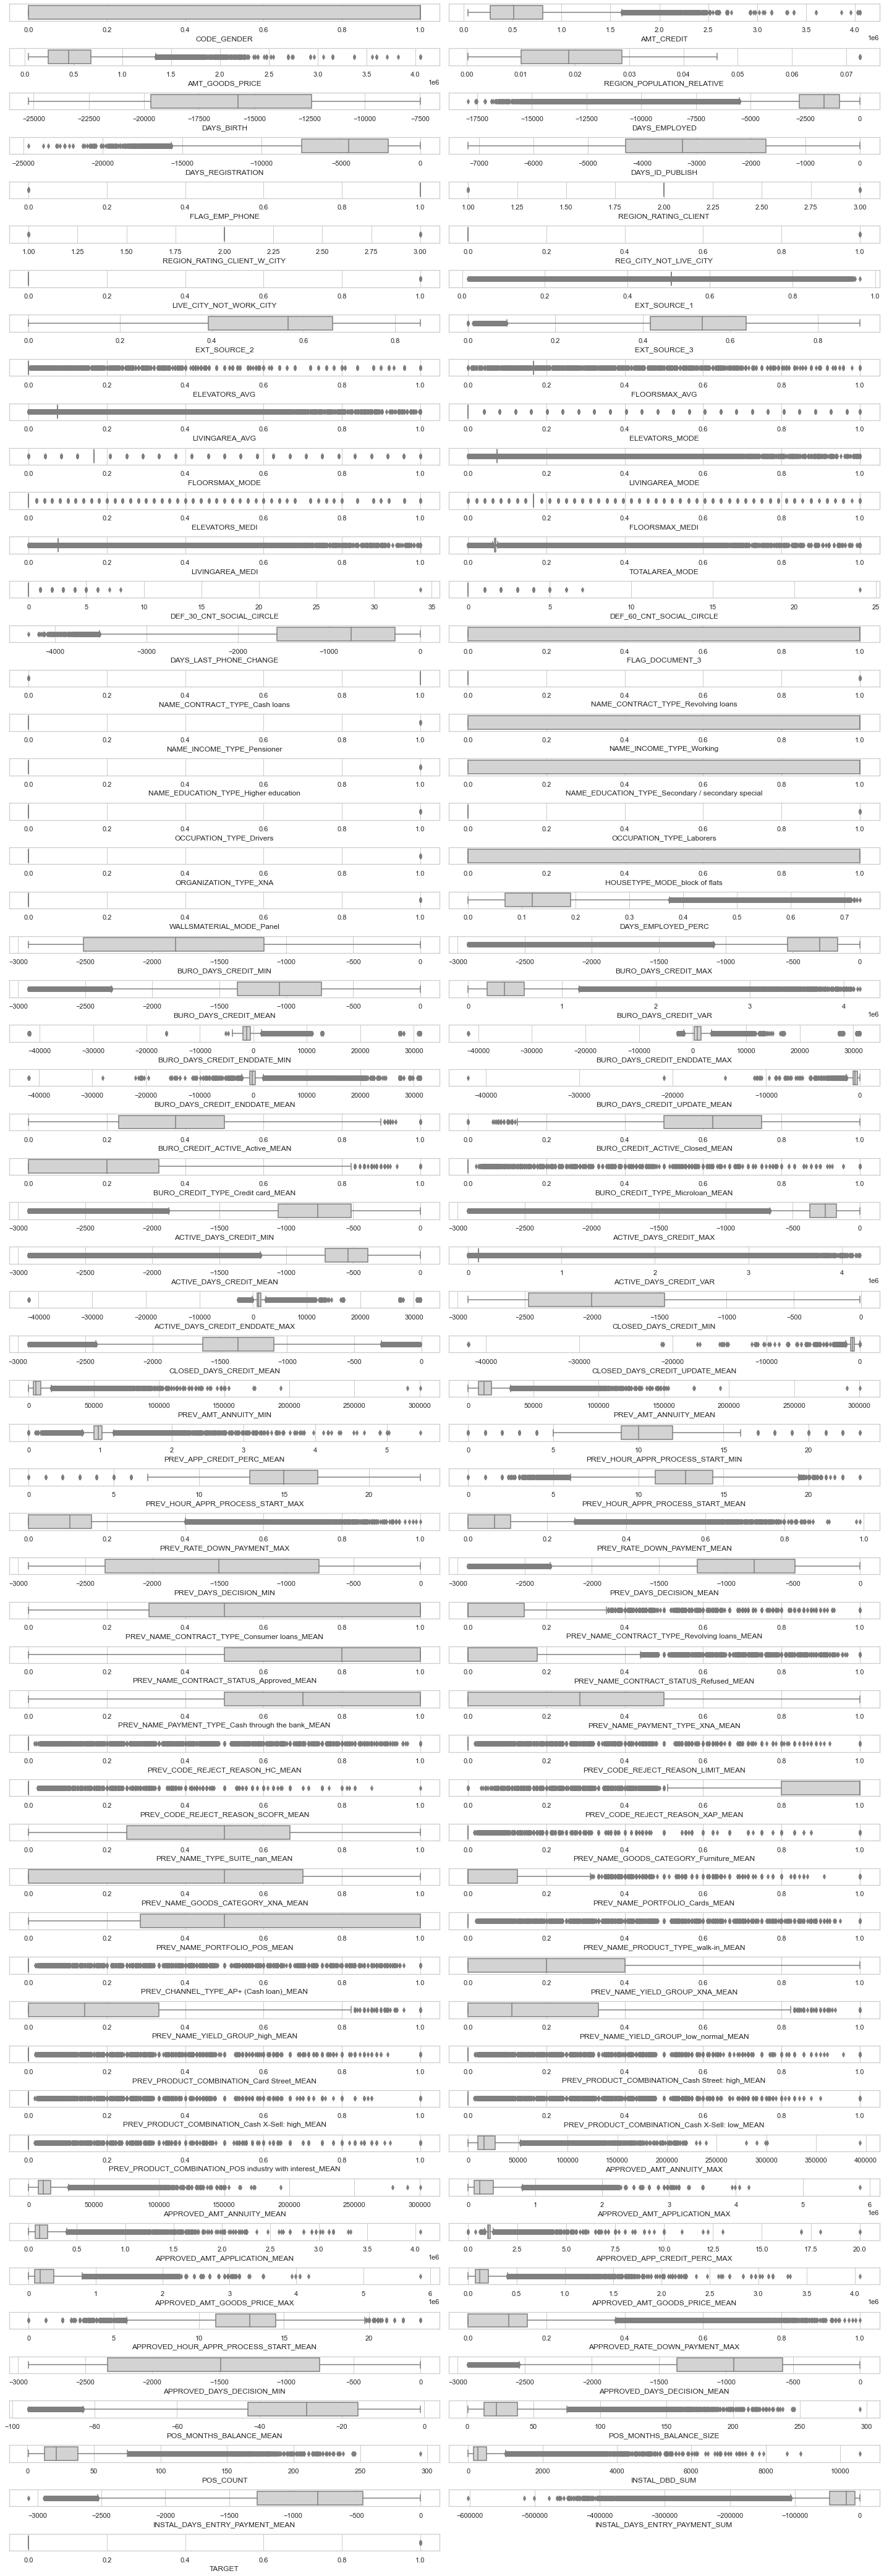

In [28]:
# Show outliers of each quantitative value

sel = quant_cols
width = 20
height = ((len(sel)+1)/2)*1

fig = plt.figure(figsize=(width, height))

for i, c in enumerate(sel,1):
    ax = fig.add_subplot((len(sel)+2)//2, 2, i)
    sns.boxplot(x=data_train[c], orient='h',
                color='lightgrey', ax=ax)
    
fig.tight_layout()

Some outliers may penalize the learning process.

We'll drop all the rows where a value is not within +/- 7 sigmas.

In [29]:
import scipy.stats as st

thresh = 7

ind_outliers = []
for col in quant_cols:
    ser_ = data_train[col]
    mask_outl = np.abs(st.zscore(ser_))>thresh
    ind_outliers.append(list(ser_.loc[mask_outl].index))

ind_outliers = list(set([i for sublist in ind_outliers for i in sublist]))

print(f"{len(ind_outliers)} rows will be dropped, i.e. \
{round(100*len(ind_outliers)/data_train.shape[0],2)}% of the rows of 'data_train'")

16197 rows will be dropped, i.e. 5.27% of the rows of 'data_train'


In [30]:
# verification that outliers are not all of the target=1 type

print('{} of outliers are target=1'.format(round(100*data_train.loc[ind_outliers,"TARGET"].sum()/len(ind_outliers),2)))
print('{}% of all the rows are target=1'.format(round(100*data_train.loc[: ,"TARGET"].sum()/data_train.shape[0],2)))

12.02 of outliers are target=1
8.07% of all the rows are target=1


Vu le nombre de TARGET == 1 total (environ 20 000) et les lignes potentiellement supprimées (environ 5 000 soit 1/4 du total, ce qui est significatif), en retirant ces valeurs extrêmes, nous risquons de **perdre en quantité d'information sur la classe minoritaire**.

Mais le traitement des outliers est nécessaire avant d'engager un modèle de ML.<br>
Je procèderai donc à leur **imputation par la médiane**, en les **convertissant** d'abord ici en **np.nan**.

L'**imputation par la médiane** sera effectuée pour chaque évaluation de modèle dans le **pipeline de pre-processing**.

On va donc remplacer les valeurs Outliers (trop nombreux) par des np.nan pour pouvoir ensuite les imputer par la médiane.

In [31]:
shape_0 = data_train.shape

In [32]:
import scipy.stats as st

thresh = 7

ind_outliers = []
for col in quant_cols:
    ser_ = data_train[col]
    mask_outl = np.abs(st.zscore(ser_))>thresh
    ser_.loc[mask_outl] = np.nan

print(f"{data_train.isnull().sum().sum()} outliers were replaced by nan, i.e. \
{round(100*data_train.isnull().sum().sum()/(data_train.shape[0]*data_train.shape[1]),2)}% of the values of 'data_train'")

24820 outliers were replaced by nan, i.e. 0.07% of the values of 'data_train'


In [33]:
# In the previous version Outliers were removed, causing a loss of information,
# that might have prejudicated the analysis / modelisation

# import scipy.stats as st

# thresh = 7

# ind_outliers = []
# for col in quant_cols:
#     ser_ = X_train[col]
#     mask_outl = np.abs(st.zscore(ser_))>thresh
#     ind_outliers.append(list(ser_.loc[mask_outl].index))

# ind_outliers = list(set([i for sublist in ind_outliers for i in sublist]))

# print(f"{len(ind_outliers)} rows will be dropped, i.e. \
# {round(100*len(ind_outliers)/X_train.shape[0],2)}% of the rows of 'X_train'")

In [34]:
shape_1 = data_train.shape

In [35]:
print(f"{shape_1[0] - shape_0[0]} rows have been dropped from data_train, i.e. \
{round(100*(shape_1[0] - shape_0[0])/shape_0[0],2)}% of the rows of 'data_train'. shape_1 :{shape_1}")

0 rows have been dropped from data_train, i.e. 0.0% of the rows of 'data_train'. shape_1 :(307507, 115)


In [36]:
print(f"{data_train.isnull().sum().sum()} NAN devront être imputées lors du préprocessing.")

24820 NAN devront être imputées lors du préprocessing.


## | Stratified sampling

In [37]:
X = data_train.drop(columns=["TARGET"])
y = data_train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [38]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
print(y.value_counts(normalize=True))

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64
0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64
0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64


L'échantillonage stratifié sur TARGET a fonctionné : les proportions de 1 et 0 de train et test sont identiques à celles du jeu original. Le déséquilibre original du jeu de données a bien été conservé.

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246005, 114), (61502, 114), (246005,), (61502,))

On conserve une copie de X_test pour retrouver l'ID du dossier plus tard avec SHAP :

In [40]:
# on copie X_test
data = X_test.copy()
# on ajoute la target pour vérification
data["TARGET"] = y_test

In [41]:
data.head()

,CODE_GENDER,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,ELEVATORS_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,ELEVATORS_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,ELEVATORS_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_Panel,DAYS_EMPLOYED_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MEAN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_COUNT,INSTAL_DBD_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
309296,0.0,497520.0,450000.0,0.014464,-19654.0,-235.0,-13084.0,-3201.0,1.0,2.0,2.0,0.0,0.0,0.273594,0.752981,0.535276,0.00,0.1250,0.0396,0.0000,0.1250,0.0413,0.00,0.1250,0.0404,0.0323,0.0,0.0,-1550.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.011957,-1827.0,-300.0,-1050.571429,385106.566667,-1268.0,909.0,-135.577778,-481.833333,0.375000,0.625000,0.200000,0.0,-764.0,-258.0,-537.309524,1.081503e+05,1051.0,-2002.0,-1366.555556,-761.500000,15352.470,15352.470000,1.026443,5.0,5.0,5.00,0.101383,0.101383,-1550.0,-1550.000,1.00,0.00,1.00,0.000,0.000,1.000,0.0,0.0,0.0,1.000,0.00,0.0,0.00,0.00,1.00,0.000,0.0,0.000,0.000,1.00,0.00,0.0,0.0,0.000,0.0,15352.470,15352.4700,141840.0,141840.00,1.026443,141840.0,141840.00,5.000000,0.101383,-1550.0,-1550.0,-46.000000,11.0,11.0,8

In [47]:
# preparation for SHAP feature importance
# reduce test dataset to 10 000 observations
# initial dataset too heavy to be loaded on GitHub too

# Backup sample X_test
joblib.dump(X_test.iloc[0:10000,:], 'Models/X_test.pkl')

# Backup sample y_test
joblib.dump(y_test[0:10000], 'Models/y_test.pkl')

['Models/y_test.pkl']

## | Dataframe for result collection

In [42]:
# Création d'un dataframe pour visaliser les scores selon le modèle utilisé
data_type = pd.Series(['Train', 'Test', 'Train', 'Test', 'Train', 'Test', 'Train',
                       'Test', 'Train', 'Test', 'Train', 'Test', 'Train', 'Test'])
data_model = pd.Series(['Dummy', 'Dummy', 'LogReg', 'LogReg', 'RandFor', 'RandFor',
                        'CatBoost', 'CatBoost', 'XGBC', 'XGBC',
                        'LightGBM', 'LightGBM', 'LightGBM_NS', 'LightGBM_NS'])

frame = {'Data': data_type, 'Model': data_model,
         'Custom_score': '', 'Time': '', 'ROC_AUC': '', 'PR_AUC': ''}

model_scores = pd.DataFrame(frame)

In [43]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,,,,
1,Test,Dummy,,,,
2,Train,LogReg,,,,
3,Test,LogReg,,,,
4,Train,RandFor,,,,
5,Test,RandFor,,,,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


# | Model testing

## | Baseline - Dummy Classifier

### | Model definition

In [44]:
dummy_clf = DummyClassifier(strategy='most_frequent',
                            random_state=42)

### | Fit / Train

In [45]:
%%time
start1 = time.time()

dummy_clf.fit(X_train, y_train)

end1 = time.time()

CPU times: total: 0 ns
Wall time: 8 ms


In [46]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = dummy_clf.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = dummy_clf.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = dummy_clf.predict_proba(X_train)[:, 1]>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  1%|▊                                                                                 | 1/100 [00:00<00:13,  7.35it/s]

0.0


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


In [47]:
confusion_matrix(y_train, y_pred1).ravel()

array([226145,      0,  19860,      0], dtype=int64)

In [48]:
confusion_matrix(y_train, y_pred1)

array([[226145,      0],
       [ 19860,      0]], dtype=int64)

In [49]:
best_thresh

0.0

In [50]:
best_custom_score

0.8073006646206378

In [51]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.5000
custom_score_train : 0.8073
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    226145
         1.0       0.00      0.00      0.00     19860

    accuracy                           0.92    246005
   macro avg       0.46      0.50      0.48    246005
weighted avg       0.85      0.92      0.88    246005



### | Predict / Test

In [52]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = dummy_clf.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = dummy_clf.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 31.2 ms
Wall time: 39 ms


In [53]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.5000
custom_score_test : 0.8073
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [54]:
# vérif calcul custom_score
FN=19860
FP=0
indiv_train=246005
Verif_CS_Dummy = (FP+10*FN)/(10*indiv_train)

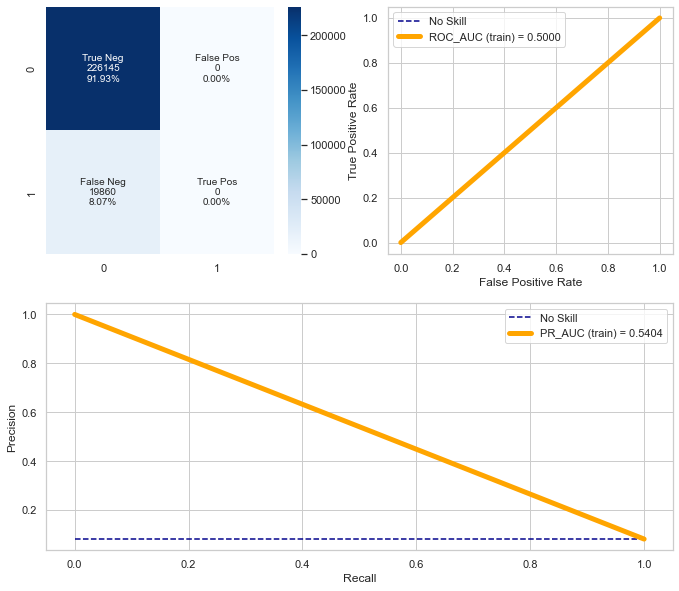

In [55]:
cf_matrix_roc_auc(dummy_clf, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

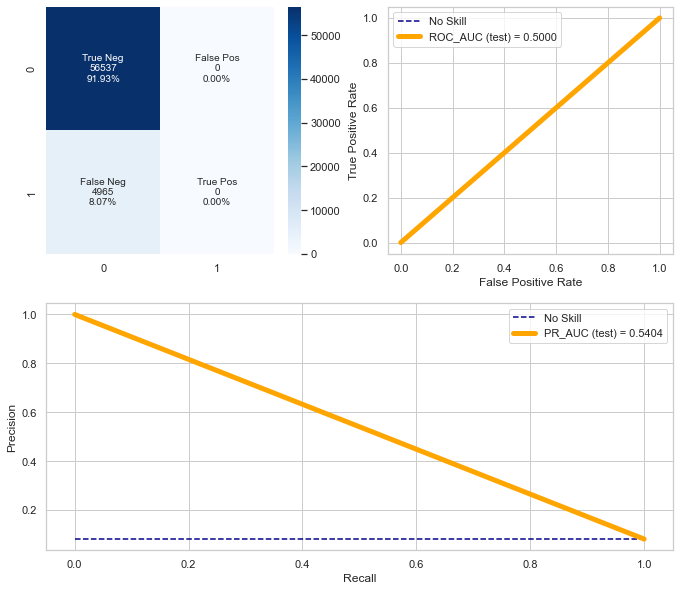

In [56]:
cf_matrix_roc_auc(dummy_clf, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores

In [57]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='Dummy'),'Time'] = round(end1-start1,4)

In [58]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='Dummy'),'Time'] = round(end2-start2,4)

In [59]:
# On conserve ces résultats pour un graphique comparatif
Dummy_y_pred1, Dummy_y_pred_proba1, Dummy_y_pred2, Dummy_y_pred_proba2, Dummy_roc_auc1, Dummy_roc_auc2 =\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [60]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,,,,
3,Test,LogReg,,,,
4,Train,RandFor,,,,
5,Test,RandFor,,,,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


## | Logistic Regression

### | Model & Gridsearch params definition

In [61]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state=42,
                                                                  max_iter=1000)]])

In [62]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier',
                 LogisticRegression(max_iter=1000, random_state=42)]])

In [63]:
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [64]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [65]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

### | Fit / Train

In [66]:
%%time
start1 = time.time()

grid.fit(X_train, y_train)

end1 = time.time()

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ................................classifier__C=0.001; total time=   5.7s
[CV] END ................................classifier__C=0.001; total time=   5.6s
[CV] END ................................classifier__C=0.001; total time=   5.7s
[CV] END .................................classifier__C=0.01; total time=   9.5s
[CV] END .................................classifier__C=0.01; total time=  10.6s
[CV] END .................................classifier__C=0.01; total time=   8.9s
[CV] END ..................................classifier__C=0.1; total time=  14.4s
[CV] END ..................................classifier__C=0.1; total time=  15.8s
[CV] END ..................................classifier__C=0.1; total time=  20.8s
[CV] END ....................................classifier__C=1; total time=  14.7s
[CV] END ....................................classifier__C=1; total time=  19.0s
[CV] END ....................................clas

In [67]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|█▋                                                                                | 2/100 [00:00<00:13,  7.30it/s]

0.0
0.010101010101010102


  4%|███▎                                                                              | 4/100 [00:00<00:13,  7.38it/s]

0.020202020202020204
0.030303030303030304


  6%|████▉                                                                             | 6/100 [00:00<00:12,  7.43it/s]

0.04040404040404041
0.05050505050505051


  8%|██████▌                                                                           | 8/100 [00:01<00:12,  7.42it/s]

0.06060606060606061
0.07070707070707072


 10%|████████                                                                         | 10/100 [00:01<00:12,  7.44it/s]

0.08080808080808081
0.09090909090909091


 12%|█████████▋                                                                       | 12/100 [00:01<00:11,  7.42it/s]

0.10101010101010102
0.11111111111111112


 14%|███████████▎                                                                     | 14/100 [00:01<00:11,  7.40it/s]

0.12121212121212122
0.13131313131313133


 16%|████████████▉                                                                    | 16/100 [00:02<00:11,  7.38it/s]

0.14141414141414144
0.15151515151515152


 18%|██████████████▌                                                                  | 18/100 [00:02<00:11,  7.34it/s]

0.16161616161616163
0.17171717171717174


 20%|████████████████▏                                                                | 20/100 [00:02<00:10,  7.32it/s]

0.18181818181818182
0.19191919191919193


 22%|█████████████████▊                                                               | 22/100 [00:02<00:10,  7.28it/s]

0.20202020202020204
0.21212121212121213


 24%|███████████████████▍                                                             | 24/100 [00:03<00:10,  7.29it/s]

0.22222222222222224
0.23232323232323235


 26%|█████████████████████                                                            | 26/100 [00:03<00:10,  7.28it/s]

0.24242424242424243
0.25252525252525254


 28%|██████████████████████▋                                                          | 28/100 [00:03<00:09,  7.27it/s]

0.26262626262626265
0.27272727272727276


 30%|████████████████████████▎                                                        | 30/100 [00:04<00:09,  7.23it/s]

0.2828282828282829
0.29292929292929293


 32%|█████████████████████████▉                                                       | 32/100 [00:04<00:09,  7.22it/s]

0.30303030303030304
0.31313131313131315


 34%|███████████████████████████▌                                                     | 34/100 [00:04<00:09,  7.23it/s]

0.32323232323232326
0.33333333333333337


 36%|█████████████████████████████▏                                                   | 36/100 [00:04<00:08,  7.19it/s]

0.3434343434343435
0.3535353535353536


 38%|██████████████████████████████▊                                                  | 38/100 [00:05<00:08,  7.15it/s]

0.36363636363636365
0.37373737373737376


 40%|████████████████████████████████▍                                                | 40/100 [00:05<00:08,  7.20it/s]

0.38383838383838387
0.393939393939394


 42%|██████████████████████████████████                                               | 42/100 [00:05<00:08,  7.13it/s]

0.4040404040404041
0.4141414141414142


 44%|███████████████████████████████████▋                                             | 44/100 [00:06<00:07,  7.11it/s]

0.42424242424242425
0.43434343434343436


 46%|█████████████████████████████████████▎                                           | 46/100 [00:06<00:07,  7.10it/s]

0.4444444444444445
0.4545454545454546


 48%|██████████████████████████████████████▉                                          | 48/100 [00:06<00:07,  7.12it/s]

0.4646464646464647
0.4747474747474748


 50%|████████████████████████████████████████▌                                        | 50/100 [00:06<00:06,  7.15it/s]

0.48484848484848486
0.494949494949495


 52%|██████████████████████████████████████████                                       | 52/100 [00:07<00:06,  7.15it/s]

0.5050505050505051
0.5151515151515152


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:07<00:06,  7.20it/s]

0.5252525252525253


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:07<00:06,  7.22it/s]

0.5454545454545455


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.31it/s]


In [68]:
confusion_matrix(y_train, y_pred1)

array([[169429,  56716],
       [  7566,  12294]], dtype=int64)

In [69]:
best_thresh

0.5454545454545455

In [70]:
best_custom_score

0.5381028840877218

In [71]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7532
custom_score_train : 0.5381
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84    226145
         1.0       0.18      0.62      0.28     19860

    accuracy                           0.74    246005
   macro avg       0.57      0.68      0.56    246005
weighted avg       0.89      0.74      0.80    246005



### | Predict / Test

In [72]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 203 ms
Wall time: 203 ms


In [73]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7534
custom_score_test : 0.5377
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     56537
         1.0       0.18      0.62      0.28      4965

    accuracy                           0.74     61502
   macro avg       0.57      0.68      0.56     61502
weighted avg       0.89      0.74      0.79     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [74]:
# vérif calcul custom_score
FN=6597
FP=68759
indiv_train=246005
Verif_CS_LogReg = (FP+10*FN)/(10*indiv_train)

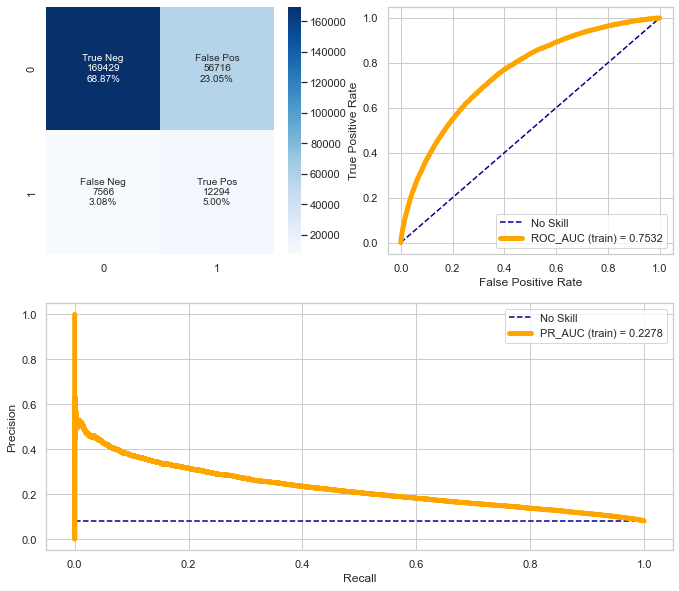

In [75]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

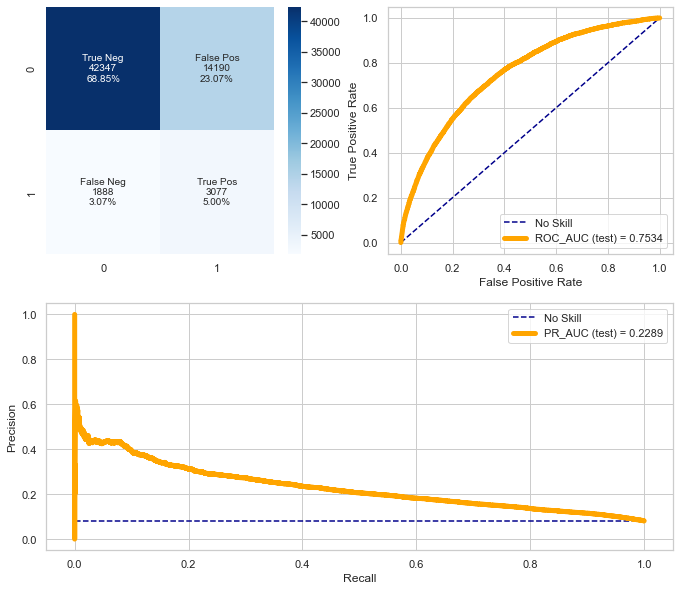

In [76]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [77]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LogReg'),'Time'] = round(end1-start1,4)

In [78]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LogReg'),'Time'] = round(end2-start2,4)

In [79]:
# On conserve ces résultats pour un graphique comparatif
LogReg_y_pred1, LogReg_y_pred_proba1, LogReg_y_pred2, LogReg_y_pred_proba2, LogReg_roc_auc1, LogReg_roc_auc2 =\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [80]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,0.5381,381.7091,0.7532,
3,Test,LogReg,0.5377,0.203,0.7534,
4,Train,RandFor,,,,
5,Test,RandFor,,,,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


In [81]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42)]])

In [82]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LogReg.joblib')
# model = joblib.load('Models/best_model_LogReg.joblib') to load it back

['Models/best_model_LogReg.joblib']

In [83]:
joblib.dump(best_thresh, 'Models/best_thresh_LogReg.joblib')
# best_thresh = joblib.load('Models/best_thresh_LogReg.joblib') to load it back

['Models/best_thresh_LogReg.joblib']

## | Random Forest Classifier

### | Model & Gridsearch params definition

In [84]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', RandomForestClassifier(random_state=42)]])

In [85]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier', RandomForestClassifier(random_state=42)]])

In [86]:
# Set hyperparamteters range

# number of trees in the random forest
n_estimators = [3, 4, 5, 6, 7] 
# number of features in consideration at every split
max_features = ['sqrt']
# minimum sample number that can be stored in a leaf node
# smaller leaves = model more prone to capturing noise in train data
min_samples_leaf = [45, 50, 55]

In [87]:
param_grid = {'classifier__n_estimators': n_estimators,
              'classifier__max_features': max_features,
              'classifier__min_samples_leaf': min_samples_leaf}

In [88]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [89]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

### | Fit / Train

In [90]:
%%time
start1 = time.time()

grid.fit(X_train, y_train)

end1 = time.time()

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   5.5s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   5.2s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=3; total time=   5.7s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   6.7s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   6.6s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=4; total time=   7.1s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=5; total time=   8.1s
[CV] END classifier__max_features=sqrt, classifier__min_samples_leaf=45, classifier__n_estimators=5

In [91]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|█▋                                                                                | 2/100 [00:00<00:13,  7.36it/s]

0.0
0.010101010101010102


  4%|███▎                                                                              | 4/100 [00:00<00:13,  7.35it/s]

0.020202020202020204
0.030303030303030304


  6%|████▉                                                                             | 6/100 [00:00<00:12,  7.36it/s]

0.04040404040404041
0.05050505050505051


  8%|██████▌                                                                           | 8/100 [00:01<00:12,  7.27it/s]

0.06060606060606061
0.07070707070707072


 10%|████████                                                                         | 10/100 [00:01<00:12,  7.24it/s]

0.08080808080808081
0.09090909090909091


 12%|█████████▋                                                                       | 12/100 [00:01<00:12,  7.24it/s]

0.10101010101010102
0.11111111111111112


 14%|███████████▎                                                                     | 14/100 [00:01<00:11,  7.23it/s]

0.12121212121212122
0.13131313131313133


 16%|████████████▉                                                                    | 16/100 [00:02<00:11,  7.21it/s]

0.14141414141414144
0.15151515151515152


 18%|██████████████▌                                                                  | 18/100 [00:02<00:11,  7.23it/s]

0.16161616161616163
0.17171717171717174


 20%|████████████████▏                                                                | 20/100 [00:02<00:11,  7.26it/s]

0.18181818181818182


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


In [92]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7582
custom_score_train : 0.5383
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80    226145
         1.0       0.16      0.70      0.26     19860

    accuracy                           0.68    246005
   macro avg       0.56      0.69      0.53    246005
weighted avg       0.90      0.68      0.75    246005



### | Predict / Test

In [93]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 297 ms
Wall time: 295 ms


In [94]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.6688
custom_score_test : 0.6464
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     56537
         1.0       0.13      0.58      0.22      4965

    accuracy                           0.66     61502
   macro avg       0.54      0.62      0.50     61502
weighted avg       0.88      0.66      0.74     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [95]:
# vérif calcul custom_score
FN=17835
FP=4276
indiv_train=246005
Verif_CS_RandFor = (FP+10*FN)/(10*indiv_train)

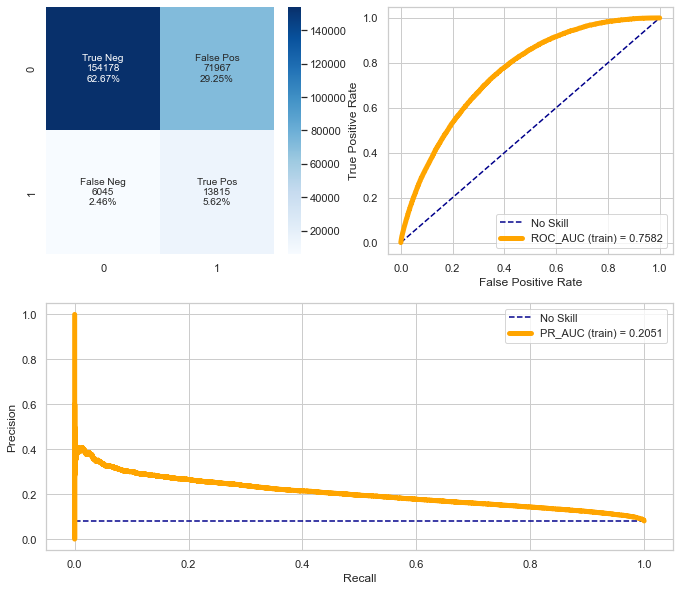

In [96]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

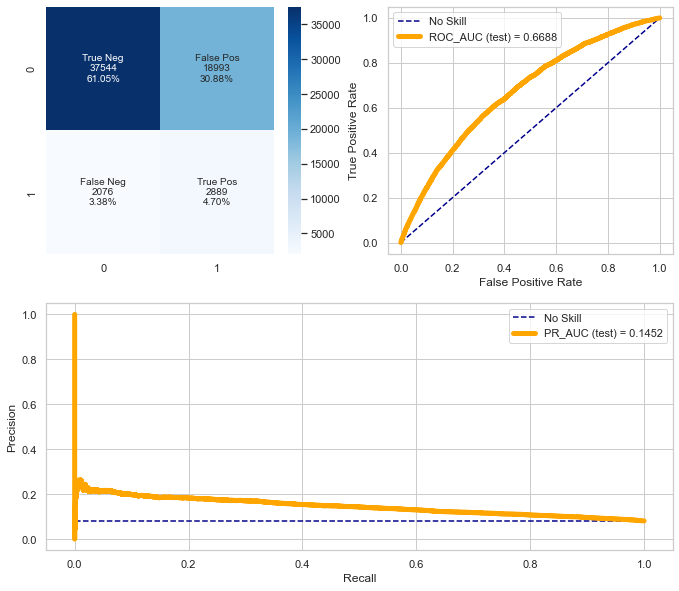

In [97]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [98]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='RandFor'),'Time'] = round(end1-start1,4)

In [99]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='RandFor'),'Time'] = round(end2-start2,4)

In [100]:
# On conserve ces résultats pour un graphique comparatif
RandFor_y_pred1, RandFor_y_pred_proba1, RandFor_y_pred2, RandFor_y_pred_proba2, RandFor_roc_auc1, RandFor_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [101]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,0.5381,381.7091,0.7532,
3,Test,LogReg,0.5377,0.203,0.7534,
4,Train,RandFor,0.5383,407.7483,0.7582,
5,Test,RandFor,0.6464,0.2951,0.6688,
6,Train,CatBoost,,,,
7,Test,CatBoost,,,,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


In [102]:
joblib.dump(grid.best_estimator_, 'Models/best_model_RandFor.joblib')
# model = joblib.load('Models/best_model_RandFor.joblib') to load it back

['Models/best_model_RandFor.joblib']

In [103]:
joblib.dump(best_thresh, 'Models/best_thresh_RandFor.joblib')
# best_thresh = joblib.load('Models/best_thresh_RandFor.joblib') to load it back

['Models/best_thresh_RandFor.joblib']

## | Cat Boost Classifier

### | Model & Gridsearch params definition

In [104]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', CatBoostClassifier(logging_level='Silent', random_state=42)]])

In [105]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000025B51A25D90>]])

In [106]:
# Set hyperparamteters range

max_depth = [3, 4, 6]

n_estimators = [100, 200, 300]

In [107]:
param_grid = {'classifier__max_depth': max_depth,
              'classifier__n_estimators': n_estimators}

In [108]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [109]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

### | Fit / Train

In [110]:
%%time
start1 = time.time()

grid.fit(X_train, y_train)

end1 = time.time()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END classifier__max_depth=3, classifier__n_estimators=100; total time=  11.0s
[CV] END classifier__max_depth=3, classifier__n_estimators=100; total time=  10.7s
[CV] END classifier__max_depth=3, classifier__n_estimators=100; total time=  10.7s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  13.1s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  13.2s
[CV] END classifier__max_depth=3, classifier__n_estimators=200; total time=  16.3s
[CV] END classifier__max_depth=3, classifier__n_estimators=300; total time=  14.8s
[CV] END classifier__max_depth=3, classifier__n_estimators=300; total time=  14.7s
[CV] END classifier__max_depth=3, classifier__n_estimators=300; total time=  14.9s
[CV] END classifier__max_depth=4, classifier__n_estimators=100; total time=  11.1s
[CV] END classifier__max_depth=4, classifier__n_estimators=100; total time=  11.1s
[CV] END classifier__max_de

In [111]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|█▋                                                                                | 2/100 [00:00<00:13,  7.31it/s]

0.0
0.010101010101010102


  4%|███▎                                                                              | 4/100 [00:00<00:13,  7.23it/s]

0.020202020202020204
0.030303030303030304


  6%|████▉                                                                             | 6/100 [00:00<00:13,  7.17it/s]

0.04040404040404041
0.05050505050505051


  8%|██████▌                                                                           | 8/100 [00:01<00:12,  7.17it/s]

0.06060606060606061
0.07070707070707072


 10%|████████                                                                         | 10/100 [00:01<00:12,  7.13it/s]

0.08080808080808081
0.09090909090909091


 12%|█████████▋                                                                       | 12/100 [00:01<00:12,  7.20it/s]

0.10101010101010102


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


In [112]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.8286
custom_score_train : 0.4342
              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87    226145
         1.0       0.23      0.70      0.34     19860

    accuracy                           0.78    246005
   macro avg       0.60      0.75      0.61    246005
weighted avg       0.91      0.78      0.83    246005



### | Predict / Test

In [113]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 453 ms
Wall time: 212 ms


In [114]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7512
custom_score_test : 0.5391
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     56537
         1.0       0.19      0.59      0.28      4965

    accuracy                           0.76     61502
   macro avg       0.57      0.68      0.57     61502
weighted avg       0.89      0.76      0.81     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

In [115]:
# vérif calcul custom_score
FN=17811
FP=435
indiv_train=246005
Verif_CS_CatBoost = (FP+10*FN)/(10*indiv_train)

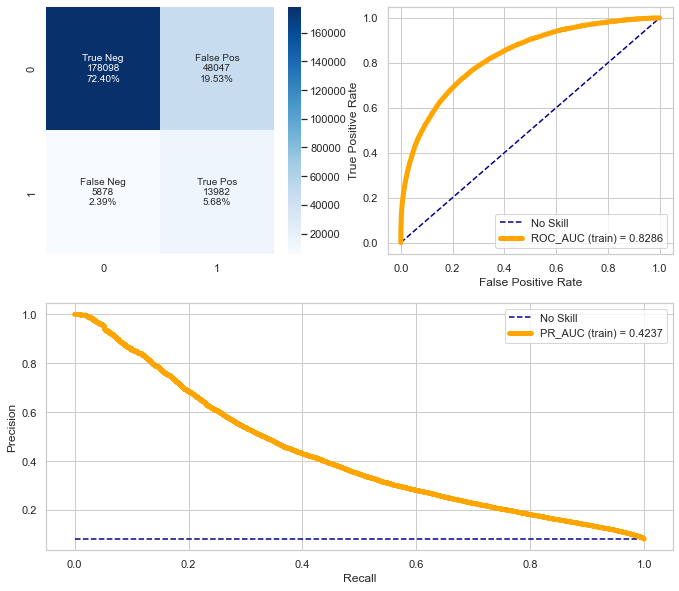

In [116]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

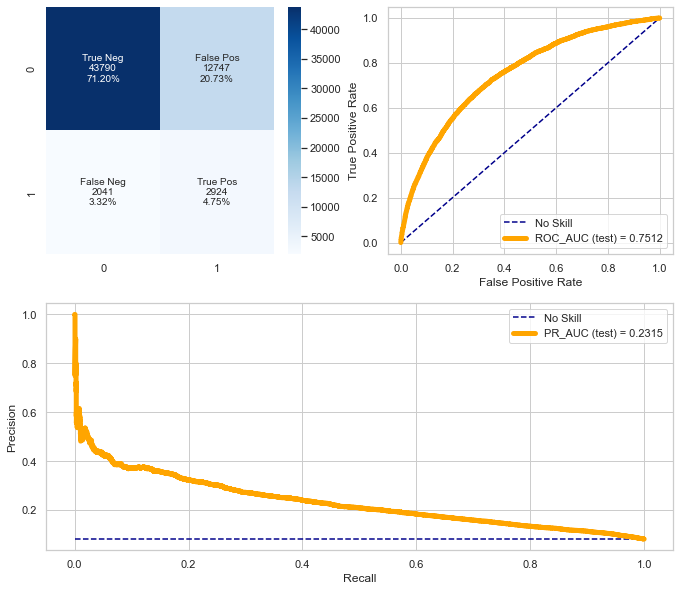

In [117]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [118]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='CatBoost'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='CatBoost'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='CatBoost'),'Time'] = round(end1-start1,4)

In [119]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='CatBoost'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='CatBoost'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='CatBoost'),'Time'] = round(end2-start2,4)

In [120]:
# On conserve ces résultats pour un graphique comparatif
CatBoost_y_pred1, CatBoost_y_pred_proba1, CatBoost_y_pred2, CatBoost_y_pred_proba2, CatBoost_roc_auc1, CatBoost_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [121]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,0.5381,381.7091,0.7532,
3,Test,LogReg,0.5377,0.203,0.7534,
4,Train,RandFor,0.5383,407.7483,0.7582,
5,Test,RandFor,0.6464,0.2951,0.6688,
6,Train,CatBoost,0.4342,419.8439,0.8286,
7,Test,CatBoost,0.5391,0.212,0.7512,
8,Train,XGBC,,,,
9,Test,XGBC,,,,


In [122]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000025B51A303A0>]])

In [123]:
grid.best_params_

{'classifier__max_depth': 6, 'classifier__n_estimators': 200}

In [124]:
joblib.dump(grid.best_estimator_, 'Models/best_model_CatBoost.joblib')
# model = joblib.load('Models/best_model_CatBoost.joblib') to load it back

['Models/best_model_CatBoost.joblib']

In [125]:
joblib.dump(best_thresh, 'Models/best_thresh_CatBoost.joblib')
# best_thresh = joblib.load('Models/best_thresh_CatBoost.joblib') to load it back

['Models/best_thresh_CatBoost.joblib']

## | XGB Classifier

### | Model & Gridsearch params definition

In [126]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', XGBClassifier(random_state=42)]])

In [127]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, reg_alpha=None, reg_lambda=None, ...)]])

In [128]:
# Set hyperparamteters range

# how quickly the model fits the residual errors
# by using additional base learners
learning_rate = [0.001, 0.01, 0.05, 0.1, 0.2]

# how deep the tree's decision nodes can go. 
# Must be a positive integer
max_depth = [2, 3, 5]

# fraction of the training set that can be used to train each tree.
# too low = underfitting / too high = overfitting
subsample = [0.5, 0.7, 0.9]

# fraction of the features that can be used to train each tree
colsample_bytree = [0.5, 0.95, 0.99]

In [129]:
param_grid = {'classifier__learning_rate': learning_rate,
              'classifier__max_depth': max_depth,
              'classifier__subsample': subsample,
              'classifier__colsample_bytree': colsample_bytree}

In [130]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [131]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

### | Fit / Train

In [132]:
%%time
start1 = time.time()

grid.fit(X_train, y_train)

end1 = time.time()

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=2, classifier__subsample=0.5; total time=   9.7s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=2, classifier__subsample=0.5; total time=   8.8s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=2, classifier__subsample=0.5; total time=   9.3s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=2, classifier__subsample=0.7; total time=   9.9s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=2, classifier__subsample=0.7; total time=  10.2s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=2, classifier__subsample=0.7; total time=   9.9s
[CV] END classifier__colsample_bytree=0.5, classifier__

[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.5; total time=   8.3s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.7; total time=   9.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.7; total time=   9.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.7; total time=   8.8s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.9; total time=   9.5s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.9; total time=   9.6s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.05, classifier__max_depth=2, classifier__subsample=0.

[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=2, classifier__subsample=0.7; total time=   9.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=2, classifier__subsample=0.9; total time=   9.9s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=2, classifier__subsample=0.9; total time=   9.7s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=2, classifier__subsample=0.9; total time=   9.5s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__subsample=0.5; total time=  11.0s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__subsample=0.5; total time=  11.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__subsample=0.5; tota

[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=2, classifier__subsample=0.9; total time=  13.3s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=2, classifier__subsample=0.9; total time=  12.9s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.7s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.7s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.4s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.0s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__subsa

[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.4s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.9s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.1s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.0s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.0s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.7; total time=  16.5s
[CV] END classifier__colsample_bytree=0.95, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__subsample=0.

[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__subsample=0.5; total time=  15.6s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.9s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.7s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.5s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__subsample=0.9; total time=  19.5s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__subsample=0.9; total time=  19.0s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.001, classifier__max_depth=3, classifier

[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.5s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__subsample=0.7; total time=  17.0s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__subsample=0.9; total time=  19.0s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__subsample=0.9; total time=  18.9s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=3, classifier__subsample=0.9; total time=  18.2s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__subsample=0.5; total time=  24.5s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.05, classifier__max_depth=5, classifier__subsa

[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__subsample=0.9; total time=  18.8s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=3, classifier__subsample=0.9; total time=  18.2s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__subsample=0.5; total time=  25.0s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__subsample=0.5; total time=  24.6s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__subsample=0.5; total time=  23.6s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__subsample=0.7; total time=  26.9s
[CV] END classifier__colsample_bytree=0.99, classifier__learning_rate=0.2, classifier__max_depth=5, classifier__subsample=0.

In [133]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]

# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|█▋                                                                                | 2/100 [00:00<00:14,  6.95it/s]

0.0


 48%|██████████████████████████████████████▉                                          | 48/100 [00:06<00:07,  7.43it/s]

0.4646464646464647
0.4747474747474748


 50%|████████████████████████████████████████▌                                        | 50/100 [00:06<00:06,  7.38it/s]

0.48484848484848486
0.494949494949495


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.46it/s]


In [134]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.6163
custom_score_train : 0.7425
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89    226145
         1.0       0.13      0.25      0.17     19860

    accuracy                           0.80    246005
   macro avg       0.53      0.55      0.53    246005
weighted avg       0.86      0.80      0.83    246005



### | Predict / Test

In [135]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 3.16 s
Wall time: 271 ms


In [136]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.6199
custom_score_test : 0.7350
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     56537
         1.0       0.13      0.26      0.18      4965

    accuracy                           0.80     61502
   macro avg       0.53      0.56      0.53     61502
weighted avg       0.86      0.80      0.83     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

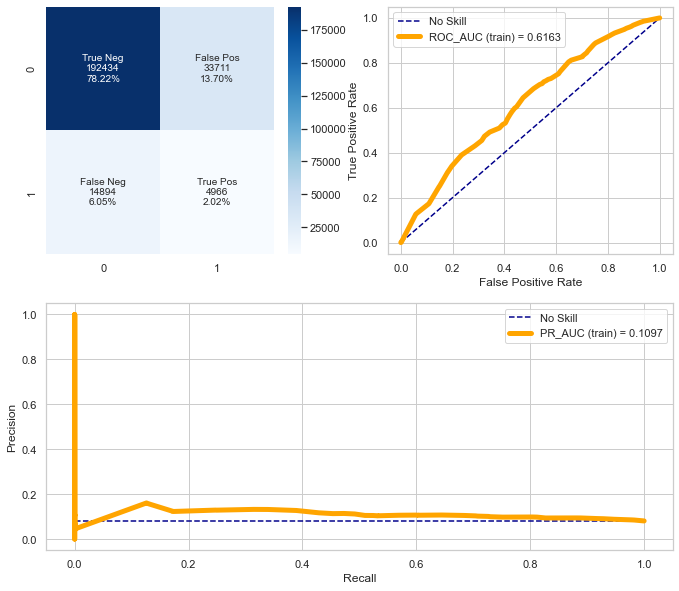

In [137]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

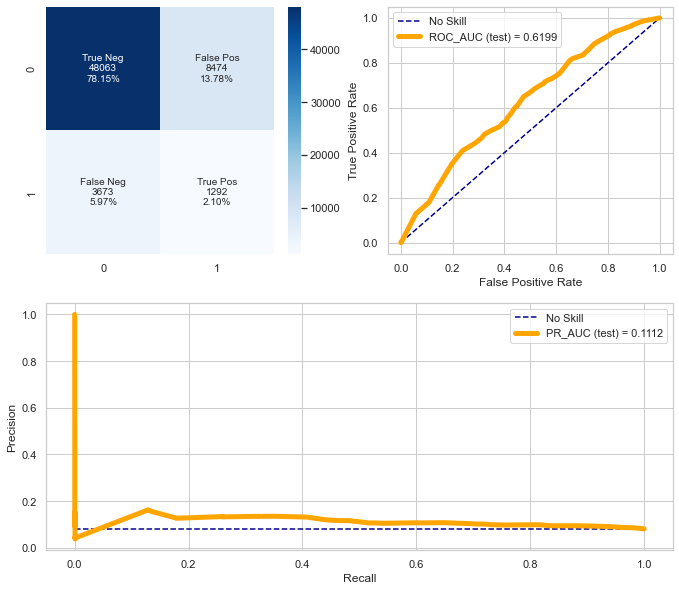

In [138]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [139]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='XGBC'),'Time'] = round(end1-start1,4)

In [140]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='XGBC'),'Time'] = round(end2-start2,4)

In [141]:
# On conserve ces résultats pour un graphique comparatif
XGBC_y_pred1, XGBC_y_pred_proba1, XGBC_y_pred2, XGBC_y_pred_proba2, XGBC_roc_auc1, XGBC_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [142]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,0.5381,381.7091,0.7532,
3,Test,LogReg,0.5377,0.203,0.7534,
4,Train,RandFor,0.5383,407.7483,0.7582,
5,Test,RandFor,0.6464,0.2951,0.6688,
6,Train,CatBoost,0.4342,419.8439,0.8286,
7,Test,CatBoost,0.5391,0.212,0.7512,
8,Train,XGBC,0.7425,6989.0395,0.6163,
9,Test,XGBC,0.735,0.2711,0.6199,


In [143]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.95,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.001, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...)]])

In [144]:
joblib.dump(grid.best_estimator_, 'Models/best_model_XGBC.joblib')
# model = joblib.load('Models/best_model_XGBC.joblib') to load it back

['Models/best_model_XGBC.joblib']

In [145]:
joblib.dump(best_thresh, 'Models/best_thresh_XGBC.joblib')
# best_thresh = joblib.load('Models/best_thresh_XGBC.joblib') to load it back

['Models/best_thresh_XGBC.joblib']

## | Light Gradient Boosting Model Classifier

### | Model & Gridsearch params definition

In [146]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state=42)]])

In [147]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['scaler', StandardScaler()],
                ['classifier', LGBMClassifier(random_state=42)]])

In [148]:
# Set hyperparamteters range

max_depth = [5, 7, 9]

subsample = [0.5, 0.75, 0.9]

reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]

colsample_bytree = [0.95, 0.97, 0.99]

In [149]:
param_grid = {'classifier__max_depth': max_depth,
              'classifier__subsample': subsample,
              'classifier__reg_lambda': reg_lambda,
              'classifier__colsample_bytree': colsample_bytree}

In [150]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [151]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

### | Fit / Train

In [152]:
%%time
start1 = time.time()

grid.fit(X_train, y_train)

end1 = time.time()

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.5; total time=   4.1s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.5; total time=   3.7s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.5; total time=   3.7s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.75; total time=   3.6s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.75; total time=   3.5s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.75; total time=   3.6s
[CV] END classifier__colsample_bytree=0.95, classifier__max_dept

[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   3.8s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   3.8s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   3.8s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.9; total time=   3.8s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.9; total time=   3.8s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.9; total time=   3.8s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.1, classifier__subsample=0.5; total tim

[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   4.1s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3.9s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.5; total time=   4.1s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.5; total time=   4.1s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.5; total time=   4.0s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.75; total time=   4.0s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.75; total time=   4.0s
[CV] EN

[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.6s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.75; total time=   3.6s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.75; total time=   3.6s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.75; total time=   3.6s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.9; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.9; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.9; total time=   3.5s
[CV] END c

[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.001, classifier__subsample=0.9; total time=   4.6s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.001, classifier__subsample=0.9; total time=   4.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.001, classifier__subsample=0.9; total time=   4.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.5; total time=   4.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.5; total time=   4.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.5; total time=   4.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.75; total t

[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.5; total time=   3.5s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.5; total time=   3.5s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.75; total time=   3.5s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.75; total time=   3.5s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.75; total time=   3.5s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3.5s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3

[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.75; total time=   3.9s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.9; total time=   3.8s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.9; total time=   3.8s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.9; total time=   3.8s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.9s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.9s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.8s
[CV] END cla

CPU times: total: 5h 31min 36s
Wall time: 29min 44s


In [153]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]


# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|█▋                                                                                | 2/100 [00:00<00:13,  7.05it/s]

0.0
0.010101010101010102


  4%|███▎                                                                              | 4/100 [00:00<00:13,  7.18it/s]

0.020202020202020204
0.030303030303030304


  6%|████▉                                                                             | 6/100 [00:00<00:13,  7.19it/s]

0.04040404040404041
0.05050505050505051


  8%|██████▌                                                                           | 8/100 [00:01<00:12,  7.18it/s]

0.06060606060606061
0.07070707070707072


 10%|████████                                                                         | 10/100 [00:01<00:12,  7.20it/s]

0.08080808080808081
0.09090909090909091


 12%|█████████▋                                                                       | 12/100 [00:01<00:12,  7.25it/s]

0.10101010101010102


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.42it/s]


In [154]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7754
custom_score_train : 0.5069
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83    226145
         1.0       0.18      0.67      0.29     19860

    accuracy                           0.73    246005
   macro avg       0.57      0.70      0.56    246005
weighted avg       0.90      0.73      0.79    246005



### | Predict / Test

In [155]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 3.44 s
Wall time: 302 ms


In [156]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7555
custom_score_test : 0.5340
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56537
         1.0       0.18      0.64      0.27      4965

    accuracy                           0.73     61502
   macro avg       0.57      0.69      0.55     61502
weighted avg       0.90      0.73      0.79     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

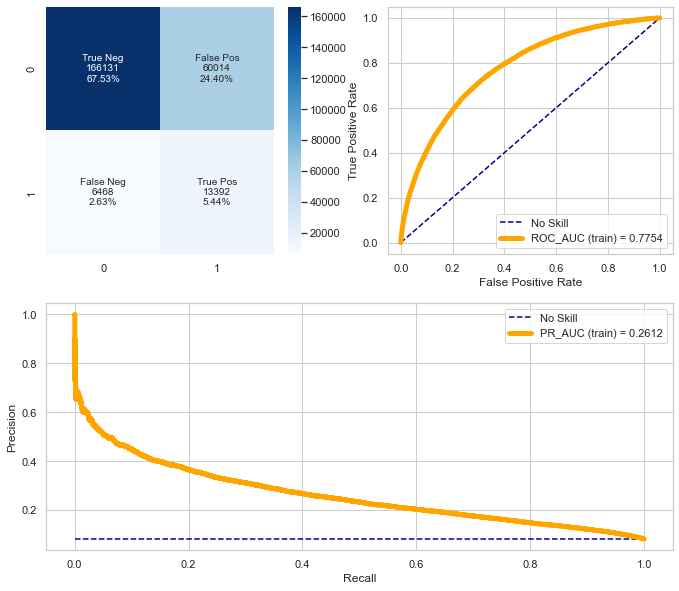

In [157]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

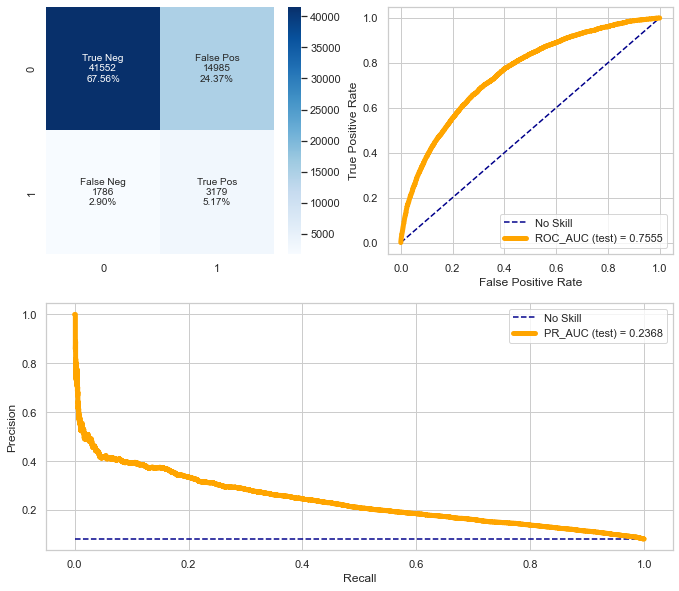

In [158]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [159]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM'),'Time'] = round(end1-start1,4)

In [160]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM'),'Time'] = round(end2-start2,4)

In [161]:
# On conserve ces résultats pour un graphique comparatif
LightGBM_y_pred1, LightGBM_y_pred_proba1, LightGBM_y_pred2, LightGBM_y_pred_proba2, LightGBM_roc_auc1, LightGBM_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [162]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,0.5381,381.7091,0.7532,
3,Test,LogReg,0.5377,0.203,0.7534,
4,Train,RandFor,0.5383,407.7483,0.7582,
5,Test,RandFor,0.6464,0.2951,0.6688,
6,Train,CatBoost,0.4342,419.8439,0.8286,
7,Test,CatBoost,0.5391,0.212,0.7512,
8,Train,XGBC,0.7425,6989.0395,0.6163,
9,Test,XGBC,0.735,0.2711,0.6199,


In [163]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 LGBMClassifier(colsample_bytree=0.97, max_depth=9,
                                random_state=42, reg_lambda=0.001,
                                subsample=0.5)]])

In [164]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LigthGBM.joblib')
# model = joblib.load('Models/best_model_LigthGBM.joblib') to load it back

['Models/best_model_LigthGBM.joblib']

In [165]:
joblib.dump(best_thresh, 'Models/best_thresh_LigthGBM.joblib')
# best_thresh = joblib.load('Models/best_thresh_LigthGBM.joblib') to load it back

['Models/best_thresh_LigthGBM.joblib']

## | Light Gradient Boosting Model Classifier - No Standardization

**Logistic regressions** and **tree-based** algorithms such as **decision trees**, **random forests** and **gradient boosting** are not sensitive to the magnitude of variables. So standardization is not needed before fitting these kinds of models.

Nevertheless, I kept this stage for every model during the search for the best model.

Once I found LGBM is the best one, I will now **feed the same model** with train data **not standardized**, so to ease the interpretation later on. 

### | Model & Gridsearch params definition

In [166]:
model = imbpipeline(steps = [["impute", SimpleImputer(missing_values=np.nan, strategy='mean')],
                             ['smote', SMOTE(random_state=42)],
                             ['classifier', LGBMClassifier(random_state=42)]])

In [167]:
model

Pipeline(steps=[['impute', SimpleImputer()], ['smote', SMOTE(random_state=42)],
                ['classifier', LGBMClassifier(random_state=42)]])

In [168]:
# Set hyperparamteters range

max_depth = [5, 7, 9]

subsample = [0.5, 0.75, 0.9]

reg_lambda = [1e-3, 1e-2, 1e-1, 1, 2]

colsample_bytree = [0.95, 0.97, 0.99]

In [169]:
param_grid = {'classifier__max_depth': max_depth,
              'classifier__subsample': subsample,
              'classifier__reg_lambda': reg_lambda,
              'classifier__colsample_bytree': colsample_bytree}

In [170]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [171]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=stratified_kfold,
                    refit='custom_score',
                    verbose=2,
                    return_train_score=True,
                    n_jobs=1)

### | Fit / Train

In [172]:
%%time
start1 = time.time()

grid.fit(X_train, y_train)

end1 = time.time()

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.5; total time=   3.5s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.5; total time=   3.0s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.5; total time=   3.0s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=5, classifier__reg_lambda=0.001, classifier__subsample=0.75; total time=   2.9s
[CV] END classifier__colsample_bytree=0.95, classifier__max_dept

[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   3.3s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   3.3s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   3.3s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.9; total time=   3.2s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.9; total time=   3.3s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.01, classifier__subsample=0.9; total time=   3.3s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=7, classifier__reg_lambda=0.1, classifier__subsample=0.5; total tim

[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3.4s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3.4s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.5; total time=   3.4s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.5; total time=   3.4s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.5; total time=   3.4s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.75; total time=   3.5s
[CV] END classifier__colsample_bytree=0.95, classifier__max_depth=9, classifier__reg_lambda=1, classifier__subsample=0.75; total time=   3.5s
[CV] EN

[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   2.9s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.75; total time=   2.9s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.9; total time=   3.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.9; total time=   3.0s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=5, classifier__reg_lambda=2, classifier__subsample=0.9; total time=   2.9s
[CV] END c

[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.001, classifier__subsample=0.9; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.001, classifier__subsample=0.9; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.001, classifier__subsample=0.9; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.5; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.5; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.5; total time=   3.5s
[CV] END classifier__colsample_bytree=0.97, classifier__max_depth=9, classifier__reg_lambda=0.01, classifier__subsample=0.75; total t

[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.5; total time=   3.1s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.5; total time=   3.0s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.75; total time=   3.0s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3.1s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=5, classifier__reg_lambda=0.1, classifier__subsample=0.9; total time=   3

[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.75; total time=   3.4s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.9; total time=   3.4s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.9; total time=   3.4s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=1, classifier__subsample=0.9; total time=   3.4s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.4s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.4s
[CV] END classifier__colsample_bytree=0.99, classifier__max_depth=7, classifier__reg_lambda=2, classifier__subsample=0.5; total time=   3.3s
[CV] END cla

CPU times: total: 5h 18min 46s
Wall time: 25min 20s


In [173]:
# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba1 = grid.predict_proba(X_train)[:, 1]


# on n'utilise pas les prédictions du modèle,
# mais celles dérivées des probabilités optimisées
# y_pred1 = grid.predict(X_train)

# optimisation sur le jeu d'entrainement
best_thresh = None
best_custom_score = 1
for thresh in tqdm(np.linspace(0, 1, 100)):
    custom_score = custom_metric(y_train, y_pred_proba1>thresh)
    if custom_score < best_custom_score:
        print(thresh)
        best_thresh = thresh
        best_custom_score = custom_score
        
# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
y_pred1 = y_pred_proba1>best_thresh

roc_auc1 = roc_auc_score(y_train, y_pred_proba1)
# Measure of the custom_score from truthful and predicted values
custom_metric1 = custom_metric(y_train, y_pred1)

  2%|█▋                                                                                | 2/100 [00:00<00:13,  7.08it/s]

0.0
0.010101010101010102


  4%|███▎                                                                              | 4/100 [00:00<00:13,  7.21it/s]

0.020202020202020204
0.030303030303030304


  6%|████▉                                                                             | 6/100 [00:00<00:13,  7.20it/s]

0.04040404040404041
0.05050505050505051


  8%|██████▌                                                                           | 8/100 [00:01<00:12,  7.21it/s]

0.06060606060606061
0.07070707070707072


 10%|████████                                                                         | 10/100 [00:01<00:12,  7.24it/s]

0.08080808080808081
0.09090909090909091


 12%|█████████▋                                                                       | 12/100 [00:01<00:12,  7.26it/s]

0.10101010101010102


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.45it/s]


In [174]:
print('AUC_train : %0.4f' % roc_auc1)
print('custom_score_train : %0.4f' % custom_metric1)
print(classification_report(y_train, y_pred1))

AUC_train : 0.7727
custom_score_train : 0.5112
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83    226145
         1.0       0.18      0.67      0.28     19860

    accuracy                           0.73    246005
   macro avg       0.57      0.70      0.56    246005
weighted avg       0.90      0.73      0.79    246005



### | Predict / Test

In [175]:
%%time
start2 = time.time()

# Test | Measure of the roc_auc from probabilities of the class with the greater label 
y_pred_proba2 = grid.predict_proba(X_test)[:, 1]

# on remplace y_pred par cette nouvelle version optimisée
# à partir des probabilités
# y_pred2 = grid.predict(X_test)
y_pred2 = grid.predict_proba(X_test)[:, 1]>best_thresh

roc_auc2 = roc_auc_score(y_test, y_pred_proba2)
# Measure of the custom_score from truthful and predicted values
custom_metric2 = custom_metric(y_test, y_pred2)

end2 = time.time()

CPU times: total: 3.28 s
Wall time: 251 ms


In [176]:
print('AUC_test : %0.4f' % roc_auc2)
print('custom_score_test : %0.4f' % custom_metric2)
print(classification_report(y_test, y_pred2))

AUC_test : 0.7539
custom_score_test : 0.5395
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56537
         1.0       0.17      0.64      0.27      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.68      0.55     61502
weighted avg       0.89      0.72      0.79     61502



### | AUC du fichier train “cross-validé” | choix meilleur modèle

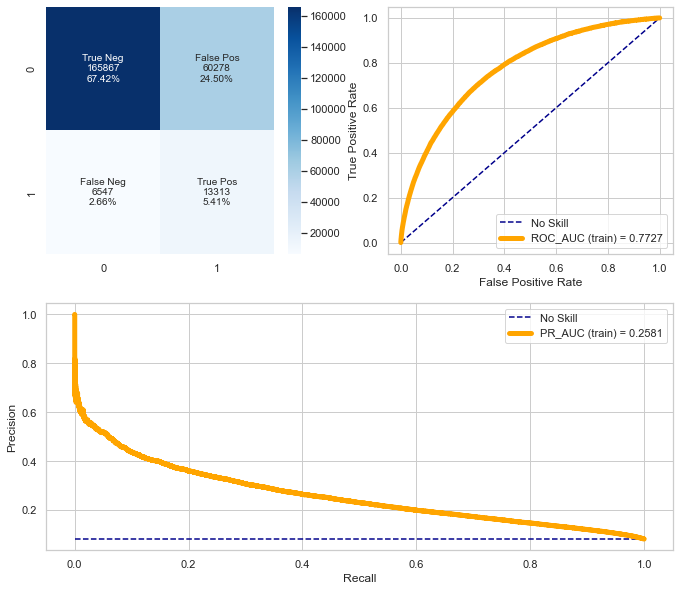

In [177]:
cf_matrix_roc_auc(grid, y_train, y_pred1, y_pred_proba1, "train")

### | AUC du fichier test | contrôle de cohérence

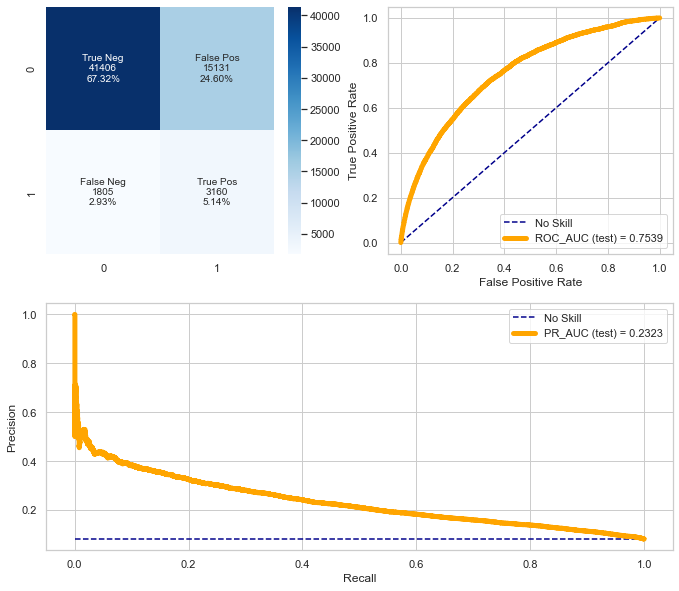

In [178]:
cf_matrix_roc_auc(grid, y_test, y_pred2, y_pred_proba2, "test")

### | Mise à jour model_scores & backup best_estimator

In [179]:
# Mise à jour des résultats / Train
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM_NS'),'Custom_score'] = round(custom_metric1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM_NS'),'ROC_AUC'] = round(roc_auc1,4)
model_scores.loc[(model_scores["Data"]=='Train') &
            (model_scores["Model"]=='LightGBM_NS'),'Time'] = round(end1-start1,4)

In [180]:
# Mise à jour des résultats / Test
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM_NS'),'Custom_score'] = round(custom_metric2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM_NS'),'ROC_AUC'] = round(roc_auc2,4)
model_scores.loc[(model_scores["Data"]=='Test') &
            (model_scores["Model"]=='LightGBM_NS'),'Time'] = round(end2-start2,4)

In [181]:
# On conserve ces résultats pour un graphique comparatif
LightGBM_NS_y_pred1, LightGBM_NS_y_pred_proba1, LightGBM_NS_y_pred2, LightGBM_NS_y_pred_proba2, LightGBM_NS_roc_auc1, LightGBM_NS_roc_auc2=\
y_pred1, y_pred_proba1, y_pred2, y_pred_proba2, roc_auc1, roc_auc2

In [182]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,
1,Test,Dummy,0.8073,0.039,0.5,
2,Train,LogReg,0.5381,381.7091,0.7532,
3,Test,LogReg,0.5377,0.203,0.7534,
4,Train,RandFor,0.5383,407.7483,0.7582,
5,Test,RandFor,0.6464,0.2951,0.6688,
6,Train,CatBoost,0.4342,419.8439,0.8286,
7,Test,CatBoost,0.5391,0.212,0.7512,
8,Train,XGBC,0.7425,6989.0395,0.6163,
9,Test,XGBC,0.735,0.2711,0.6199,


In [183]:
grid.best_estimator_

Pipeline(steps=[('impute', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ['classifier',
                 LGBMClassifier(colsample_bytree=0.99, max_depth=9,
                                random_state=42, reg_lambda=2,
                                subsample=0.5)]])

In [184]:
joblib.dump(grid.best_estimator_, 'Models/best_model_LightGBM_NS.joblib')
# model = joblib.load('Models/best_model_LigthGBM_NS.joblib') to load it back

['Models/best_model_LightGBM_NS.joblib']

In [185]:
joblib.dump(best_thresh, 'Models/best_thresh_LightGBM_NS.joblib')
# best_thresh = joblib.load('Models/best_thresh_LigthGBM_NS.joblib') to load it back

['Models/best_thresh_LightGBM_NS.joblib']

# | Selecting best model

## | Creating lists to feed graphic functions

In [186]:
pred_proba_1 = [Dummy_y_pred_proba1, LogReg_y_pred_proba1, RandFor_y_pred_proba1,\
                CatBoost_y_pred_proba1, XGBC_y_pred_proba1, LightGBM_y_pred_proba1,\
                LightGBM_NS_y_pred_proba1]

In [187]:
pred_proba_2 = [Dummy_y_pred_proba2, LogReg_y_pred_proba2, RandFor_y_pred_proba2,\
                CatBoost_y_pred_proba2, XGBC_y_pred_proba2, LightGBM_y_pred_proba2,\
                LightGBM_NS_y_pred_proba2]

In [188]:
predictions_1 = [Dummy_y_pred1, LogReg_y_pred1, RandFor_y_pred1, CatBoost_y_pred1,\
                 XGBC_y_pred1, LightGBM_y_pred1, LightGBM_NS_y_pred1]

In [189]:
predictions_2 = [Dummy_y_pred2, LogReg_y_pred2, RandFor_y_pred2, CatBoost_y_pred2,\
                 XGBC_y_pred2, LightGBM_y_pred2, LightGBM_NS_y_pred2]

In [190]:
roc_auc_1 = [Dummy_roc_auc1, LogReg_roc_auc1, RandFor_roc_auc1, CatBoost_roc_auc1,\
             XGBC_roc_auc1, LightGBM_roc_auc1, LightGBM_NS_roc_auc1]

In [191]:
roc_auc_2 = [Dummy_roc_auc2, LogReg_roc_auc2, RandFor_roc_auc2, CatBoost_roc_auc2,\
             XGBC_roc_auc2, LightGBM_roc_auc2, LightGBM_NS_roc_auc2]

## | Results visualization | recapitulative table & graphs

### | Confusion Matrix

In [192]:
print(f"Le jeu d'entrainement comporte {sum(y_train==1)} \"Default\" pour {sum(y_train==0)} \"No Default\"")

Le jeu d'entrainement comporte 19860 "Default" pour 226145 "No Default"


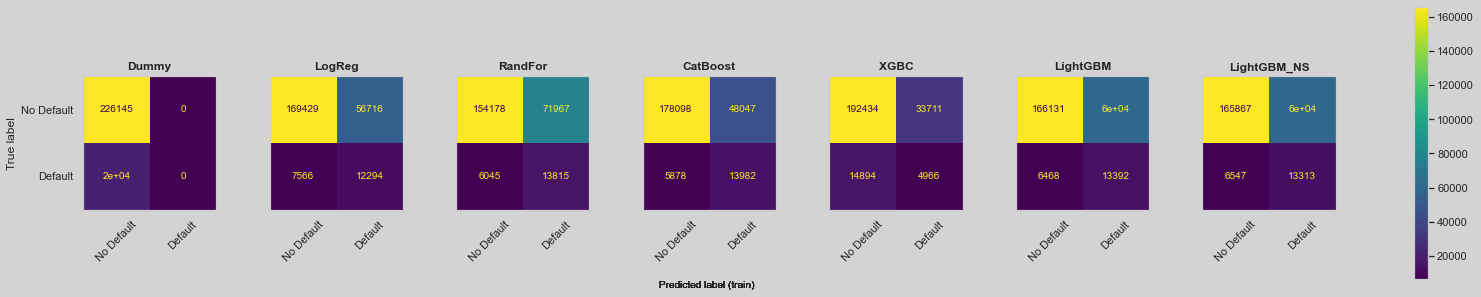

In [193]:
cf_matrix_compare("train")

In [194]:
print(f"Le jeu de test comporte {sum(y_test==1)} \"Default\" pour {sum(y_test==0)} \"No Default\"")

Le jeu de test comporte 4965 "Default" pour 56537 "No Default"


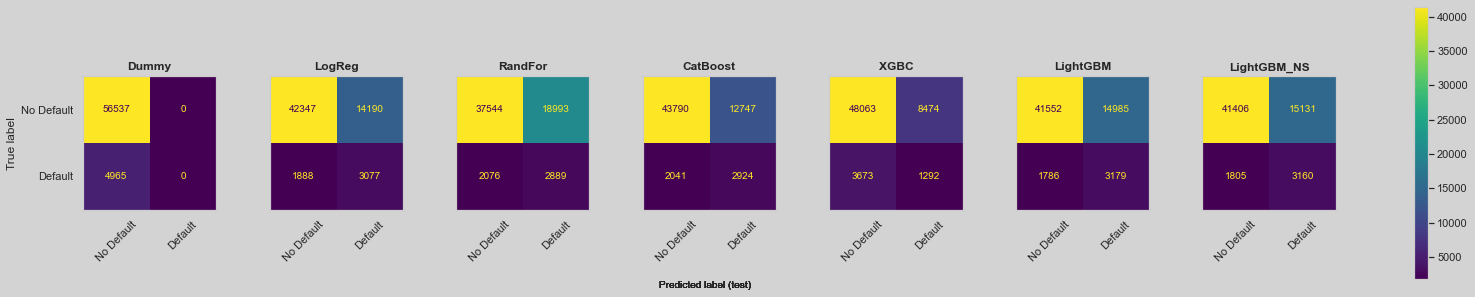

In [195]:
cf_matrix_compare("test")

### | ROC and PR Curves

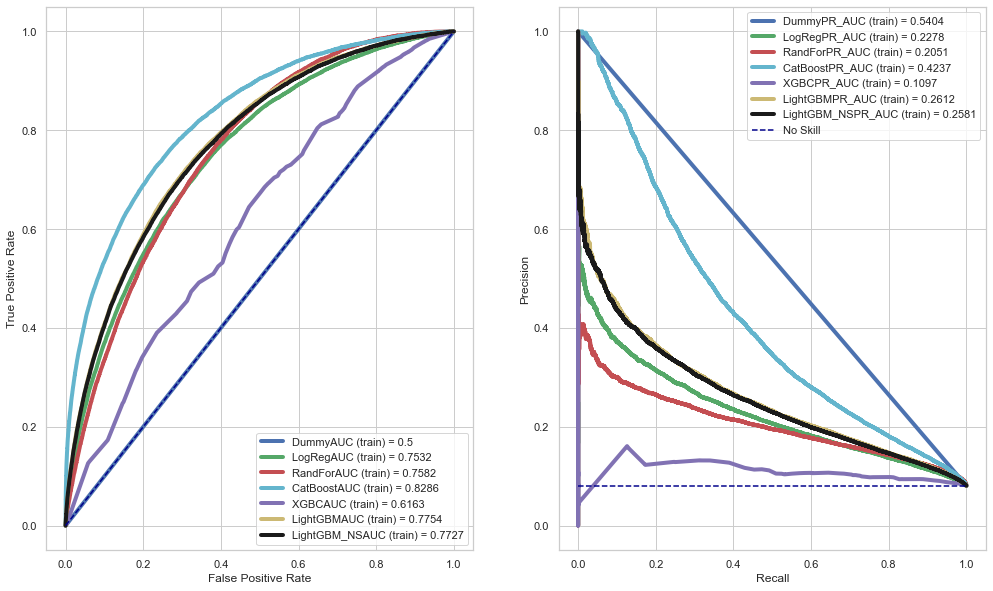

In [200]:
pr_auc_train = auc_compare("train")[0]

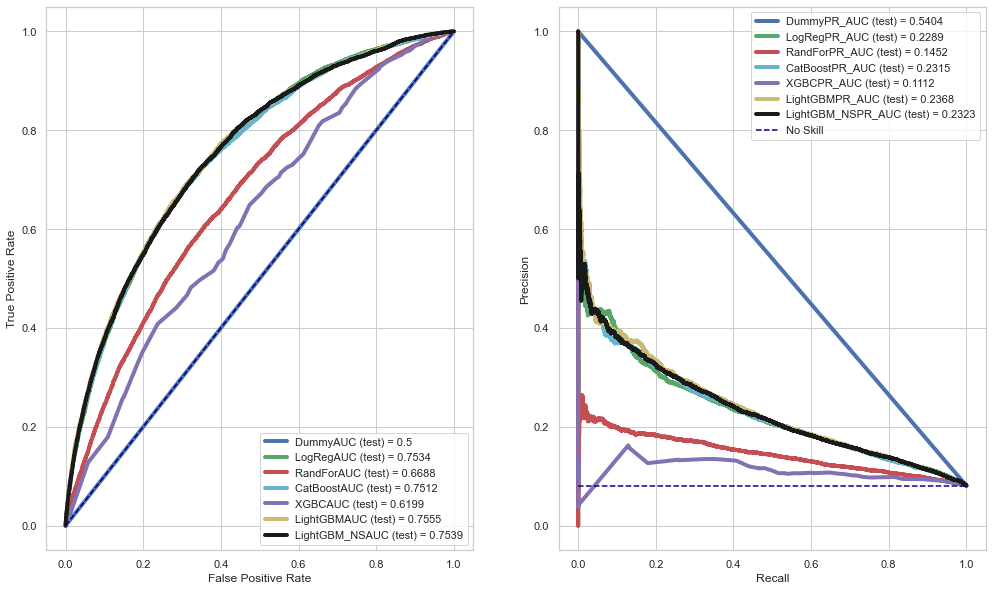

In [201]:
pr_auc_test = auc_compare("test")[1]

In [202]:
pr_auc_dict_train= {'Data':'Train', 'Model':model_names, 'PR_AUC':pr_auc_train}
pr_auc_dict_test= {'Data':'Test', 'Model':model_names, 'PR_AUC':pr_auc_test}

In [203]:
# Adding PR_AUC results to the final dataframe
df_auc_train = pd.DataFrame.from_dict(pr_auc_dict_train)
df_auc_test = pd.DataFrame.from_dict(pr_auc_dict_test)
df_auc_tot = pd.concat([df_auc_train, df_auc_test], axis=0)
model_scores_m = pd.merge(model_scores, df_auc_tot, how='left', on=['Data', 'Model'], suffixes=('_x', None))
model_scores_m.drop(columns='PR_AUC_x', inplace=True)
model_scores = model_scores_m

In [204]:
model_scores.loc[model_scores["Data"]=="Train",:].sort_values(by='Custom_score', ascending=True)

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
6,Train,CatBoost,0.4342,419.8439,0.8286,0.423731
10,Train,LightGBM,0.5069,1784.6681,0.7754,0.261194
12,Train,LightGBM_NS,0.5112,1520.6724,0.7727,0.258132
2,Train,LogReg,0.5381,381.7091,0.7532,0.227808
4,Train,RandFor,0.5383,407.7483,0.7582,0.205129
8,Train,XGBC,0.7425,6989.0395,0.6163,0.109701
0,Train,Dummy,0.8073,0.008,0.5,0.540365


Sur l'étape de l'entrainement, le modèle **CatBoost** ressort **premier** sur les critères de :
-  Custom Score
-  ROC_AUC
-  PR_AUC (Dummy mis à part)

Il est par ailleurs **3rd** sur les critères de :
-  Temps d'entrainement (derrière Dummy / Log Reg / Rand For)

In [205]:
model_scores.loc[model_scores["Data"]=="Test",:].sort_values(by='Custom_score', ascending=True)

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
11,Test,LightGBM,0.534,0.3021,0.7555,0.236795
3,Test,LogReg,0.5377,0.203,0.7534,0.228894
7,Test,CatBoost,0.5391,0.212,0.7512,0.231547
13,Test,LightGBM_NS,0.5395,0.251,0.7539,0.232267
5,Test,RandFor,0.6464,0.2951,0.6688,0.145183
9,Test,XGBC,0.735,0.2711,0.6199,0.111155
1,Test,Dummy,0.8073,0.039,0.5,0.540365


Sur l'étape de validation, le modèle CatBoost se révèle moins performant.<br>
C'est **Log Reg** qui semble **le meilleur** sur les critères de :
-  Custom_score
-  Temps de prédiction (Dummy à part)
-  ROC_AUC
-  PR_AUC (Dummy à part)

In [206]:
model_scores

,Data,Model,Custom_score,Time,ROC_AUC,PR_AUC
0,Train,Dummy,0.8073,0.008,0.5,0.540365
1,Test,Dummy,0.8073,0.039,0.5,0.540365
2,Train,LogReg,0.5381,381.7091,0.7532,0.227808
3,Test,LogReg,0.5377,0.203,0.7534,0.228894
4,Train,RandFor,0.5383,407.7483,0.7582,0.205129
5,Test,RandFor,0.6464,0.2951,0.6688,0.145183
6,Train,CatBoost,0.4342,419.8439,0.8286,0.423731
7,Test,CatBoost,0.5391,0.212,0.7512,0.231547
8,Train,XGBC,0.7425,6989.0395,0.6163,0.109701
9,Test,XGBC,0.735,0.2711,0.6199,0.111155
